In [43]:
#Numpy and Pandas 
import numpy as np
import pandas as pd

#Train test split 
from sklearn.model_selection import train_test_split

#Keras
import tensorflow.keras as keras
from keras.layers import LSTM, Bidirectional, TimeDistributed, Attention
from keras.layers import GaussianNoise, LayerNormalization
from keras.regularizers import l1,l2

#To Save Model and load
from keras.callbacks import ModelCheckpoint

# Additional Libraries 
import random
import json
import os 


#Graphics
import matplotlib.pyplot as plt
import seaborn as sns 

#Metrics 
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix, auc, classification_report
from sklearn.metrics import accuracy_score

DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/mfcc_data.json"

%matplotlib inline

In [66]:
output_dir = '/content/drive/MyDrive/Colab Notebooks/modeloutput/LSTM'

In [2]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """
    

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

In [3]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss/Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


In [7]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


Confusion Matrix 

In [5]:
def plot_Confusion(y_test,y_pred):
  plt.figure(figsize=(8,6))
  mappings = ['Dance/Electronic','Folk/Acoustic','R&B','World/Traditional','country',
              'easy listening','hip hop','latin','metal','pop','rock','set()']       
  
  confuse = confusion_matrix(y_test, y_pred)
  cm_df = pd.DataFrame(confuse, index = mappings, columns = mappings)
  cm_df.head(20)
  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actual Results')
  plt.xlabel('Predicted Results')
  plt.show()

In [15]:
from keras.layers.normalization import unit_normalization
def build_model_CNN(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """
    random.seed(123)
    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(.001), kernel_initializer='he_normal'))
    model.add(GaussianNoise(0.2))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu',  kernel_regularizer=l2(.001)))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu',  kernel_regularizer=l2(.001)))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.2))

    # output layer
    model.add(keras.layers.Dense(12, activation='softmax'))

    return model

In [75]:

def build_model_LSTM(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """
    random.seed(123)
    # build network topology
    model = keras.Sequential()

    model.add(LSTM(32, input_shape=input_shape, return_sequences=True))
    model.add(GaussianNoise(0.2))
    model.add(LayerNormalization())
    model.add(LSTM(32,dropout=0.3))
    model.add(LayerNormalization())
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dropout(0.2))

    # output layer
    model.add(keras.layers.Dense(12, activation='softmax'))



    return model

In [133]:
def build_model_LSTM_bidirectional(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """
    random.seed(123)
    # build network topology
    model = keras.Sequential()

    model.add(Bidirectional(LSTM(32, input_shape=input_shape, return_sequences=True)))
    model.add(GaussianNoise(0.2))
    model.add(LayerNormalization())
    model.add(Bidirectional(LSTM(32,dropout=0.3, return_sequences=True)))
    model.add(LayerNormalization())
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dropout(0.2))

    # output layer
    model.add(keras.layers.Dense(12, activation='softmax'))



    return model

In [134]:
def Random_Forest(X_train, y_train, X_test):
  from sklearn.ensemble import RandomForestClassifier
  clf = RandomForestClassifier(n_estimators=100)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(accuracy_score(y_test, y_pred))
  return clf
  

In [24]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

TRAIN TEST SPLIT

In [70]:
 # get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

SCale Data for LSTM

In [67]:
from sklearn.preprocessing import MinMaxScaler
def scale_Data(train, test, validation):
  scaler = MinMaxScaler(feature_range=(-1,1))
  scaler.fit(train)
  train = train.reshape(train.shape[0], train.shape[1])
  train_scalar = scaler.transform(train)
  test = test.reshape(test.shape[0], test.shape[1])
  test_scalar = scaler.transform(test)
  
  return train_scalar, test_scalar


In [16]:

#LSTM_input_shape = (X_train.shape[1], X_train.shape[2])
    # create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model_CNN(input_shape)

    # compile model
optimiser = keras.optimizers.Adam(learning_rate=1e-3,decay=1e-5)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()




Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 11, 32)       320       
                                                                 
 gaussian_noise_7 (GaussianN  (None, 128, 11, 32)      0         
 oise)                                                           
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 6, 32)        0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 64, 6, 32)         0         
                                                                 
 batch_normalization_12 (Bat  (None, 64, 6, 32)        128       
 chNormalization)                                                
                                                      

In [71]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [175]:
 # train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50,callbacks=[modelcheckpoint])

    # plot accuracy/error for training and validation
#plot_history(history)


    # evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

    # predict sample
predict(model, X_to_predict, y_to_predict)

Epoch 1/50
294/294 [==============================] - 2s 8ms/step - loss: 0.9359 - accuracy: 0.6645 - val_loss: 0.9797 - val_accuracy: 0.6644
Epoch 2/50
294/294 [==============================] - 2s 7ms/step - loss: 0.9443 - accuracy: 0.6624 - val_loss: 0.9581 - val_accuracy: 0.6567
Epoch 3/50
294/294 [==============================] - 2s 7ms/step - loss: 0.9500 - accuracy: 0.6567 - val_loss: 0.9884 - val_accuracy: 0.6512
Epoch 4/50
294/294 [==============================] - 2s 7ms/step - loss: 0.9428 - accuracy: 0.6654 - val_loss: 0.9787 - val_accuracy: 0.6448
Epoch 5/50
294/294 [==============================] - 2s 7ms/step - loss: 0.9402 - accuracy: 0.6634 - val_loss: 0.9557 - val_accuracy: 0.6614
Epoch 6/50
294/294 [==============================] - 2s 7ms/step - loss: 0.9390 - accuracy: 0.6630 - val_loss: 0.9505 - val_accuracy: 0.6618
Epoch 7/50
294/294 [==============================] - 3s 9ms/step - loss: 0.9399 - accuracy: 0.6623 - val_loss: 0.9500 - val_accuracy: 0.6678
Epoch 

*Epoch* # 38 Performed Best

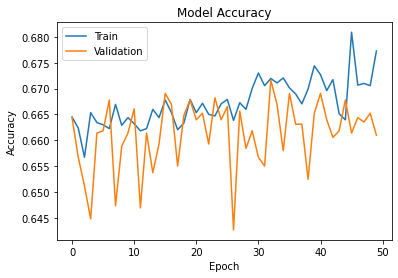

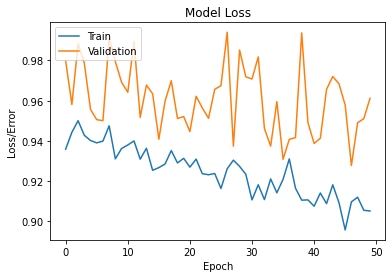

In [176]:
plot_history(history)

In [177]:
def ROC_AUC(y_valid, y_hat):
  # Compute ROC curve and ROC area for each class
  


  mappings = ['Dance/Electronic','Folk/Acoustic','R&B','World/Traditional','country',
              'easy listening','hip hop','latin','metal','pop','rock','set()']       

  # Compute ROC curve and ROC area for each class

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(11):
      
    fpr[i], tpr[i], _ = roc_curve(y_valid[:,i], y_hat[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Plot of a ROC curve for a specific class
  for i in range(11):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-AUC for {mappings[i]}')
    plt.legend(loc="lower right")
    plt.show()

NEW OUTPUT LSTM 

74/74 [==============================] - 0s 2ms/step


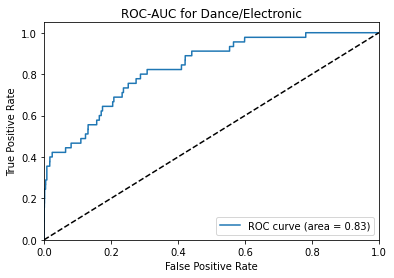

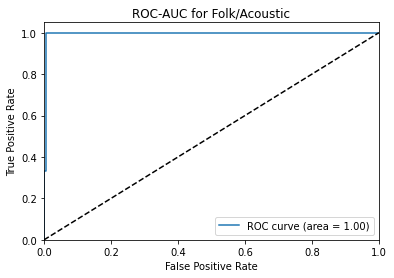

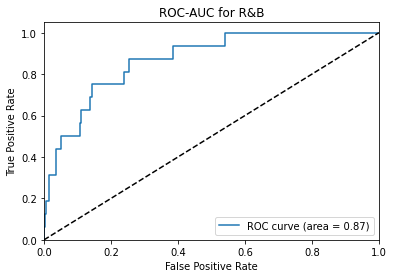

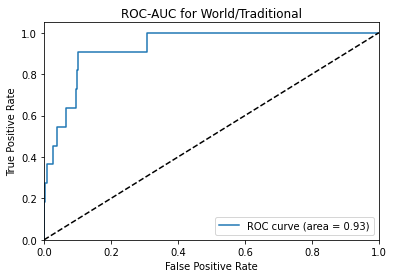

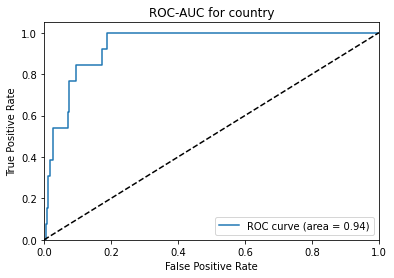

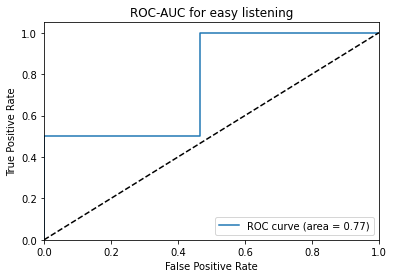

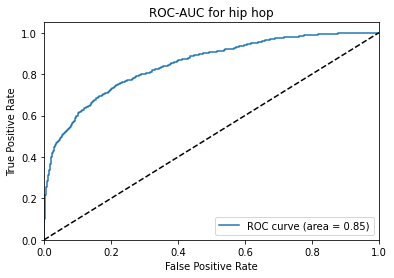

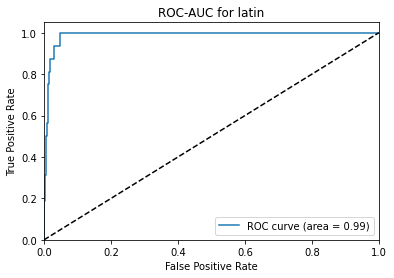

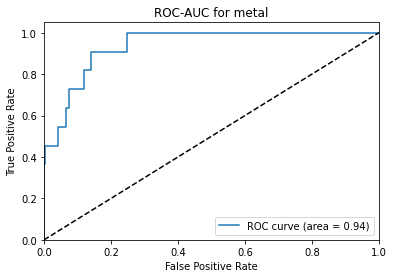

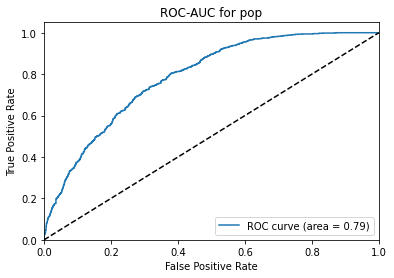

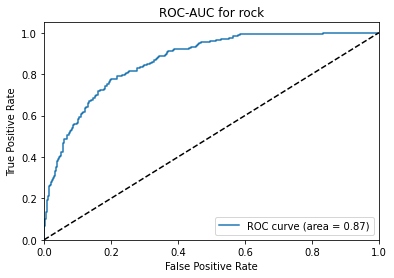

In [178]:
from sklearn.preprocessing import label_binarize
model.load_weights(output_dir+'/weights.37.hdf5')
y_binarize = label_binarize(y_validation, classes=[0,1,2,3,4,5,6,7,8,9,10,11])
y_hat = model.predict(X_validation)
#y_val = y_validation[...,np.newaxis]
y_binarize[:,1]
# df = pd.DataFrame(y_hat)
# df.head()
# y_validation_axis = y_validation[np.newaxis, ...]
# y_validation_axis.shape



    # perform prediction

# "{:0.2f}".format(roc_auc_score(y_validation, y_hat)*100.0)
ROC_AUC(y_binarize, y_hat)



Ensemble Learning 

In [158]:
 # get train, validation, test splits
#X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

CNN_weight_path = "/content/drive/MyDrive/Colab Notebooks/modeloutput/CNN/weights.35.hdf5"
LSTM_weight_path = "/content/drive/MyDrive/Colab Notebooks/modeloutput/LSTM/weights.39.hdf5"

#Input Shapes
LSTM_input_shape = (X_train.shape[1], X_train.shape[2])
CNN_input_shape = (X_train.shape[1], X_train.shape[2], 1)
BiDirect = (X_train.shape[1], X_train.shape[2], 1)

#The Models
model_CNN = build_model_CNN(CNN_input_shape)
model_LSTM = build_model_LSTM(LSTM_input_shape)
model_BiDirectional = build_model_LSTM_bidirectional(LSTM_input_shape)

# model_LSTM.load_weights(LSTM_weight_path)
model_CNN.load_weights(CNN_weight_path)




optimiser = keras.optimizers.Adam(learning_rate=1e-3,decay=1e-5)

model_CNN.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_LSTM.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
model_BiDirectional.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


In [170]:
# make an ensemble prediction for multi-class classification

from sklearn.preprocessing import label_binarize


def ensemble_predictions(members, X_test):
 # make predictions
 yhats = [this_model.predict(X_test) for this_model in members]
 yhats = np.array(yhats)

#  # sum across ensemble members
 summed = np.sum(yhats, axis=0)
 print(summed.shape)
#  # argmax across classes
 result = np.argmax(summed, axis=1)

 return result
 
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, X_test, y_test):
 # select a subset of members
 subset = members[:n_members]
 # make prediction
 yhat = ensemble_predictions(subset, X_test)
 yhat = np.array(yhat)

 y_test = y_test.reshape(-1)

 # calculate accuracy
#  y_binarize = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9,10,11])
#  ROC_AUC(y_binarize, yhat)

 return accuracy_score(y_test, yhat)

## Define Ensemble Learning Models with MFCC data

In [160]:
 # Number of Models (2)
n_models = 2
ensemble_models = []

# scaled_train, scaled_test = scale_Data(X_train, y_train)

model_LSTM.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=64, epochs=50, callbacks=[modelcheckpoint])
#model_BiDirectional.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=64, epochs=50)
model_CNN.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

# evaluate model on test set
LSTM_test_loss, LSTM_test_acc = model_LSTM.evaluate(X_test, y_test, verbose=2)
#BILSTM_test_loss, BILSTM_test_acc = model_BiDirectional.evaluate(X_test, y_test, verbose=2)
CNN_test_loss, CNN_test_acc = model_CNN.evaluate(X_test, y_test, verbose=2)

print(f'\nTest accuracy (LSTM) : \t{LSTM_test_acc}\nTest loss (LSTM) : \t{LSTM_test_loss}')
#print(f'\nTest accuracy (Bi-LSTM) : \t{BILSTM_test_acc}\nTest loss (BILSTM) : \t{BILSTM_test_loss}')
print(f'\nTest accuracy (CNN) : \t{CNN_test_acc}\nTest loss (CNN) : \t{CNN_test_loss}')

ensemble_models.append(model_LSTM)
ensemble_models.append(model_CNN)
#ensemble_models.append(model_BiDirectional)




Epoch 1/50
147/147 [==============================] - 7s 26ms/step - loss: 1.4522 - accuracy: 0.4436 - val_loss: 1.2504 - val_accuracy: 0.5209
Epoch 2/50
147/147 [==============================] - 3s 21ms/step - loss: 1.2781 - accuracy: 0.4983 - val_loss: 1.1925 - val_accuracy: 0.5605
Epoch 3/50
147/147 [==============================] - 3s 21ms/step - loss: 1.2316 - accuracy: 0.5498 - val_loss: 1.1651 - val_accuracy: 0.5779
Epoch 4/50
147/147 [==============================] - 3s 21ms/step - loss: 1.1973 - accuracy: 0.5726 - val_loss: 1.1424 - val_accuracy: 0.5877
Epoch 5/50
147/147 [==============================] - 3s 20ms/step - loss: 1.1740 - accuracy: 0.5836 - val_loss: 1.1347 - val_accuracy: 0.5843
Epoch 6/50
147/147 [==============================] - 3s 20ms/step - loss: 1.1566 - accuracy: 0.5952 - val_loss: 1.1187 - val_accuracy: 0.5903
Epoch 7/50
147/147 [==============================] - 3s 20ms/step - loss: 1.1363 - accuracy: 0.6032 - val_loss: 1.1024 - val_accuracy: 0.6035

<!-- y_binarize = label_binarize(y_validation, classes=[0,1,2,3,4,5,6,7,8,9,10,11])
y_hat = model.predict(X_validation)
y_val = y_validation[...,np.newaxis]
y_binarize[:,1] -->

In [171]:
model_LSTM.load_weights("/content/drive/MyDrive/Colab Notebooks/modeloutput/LSTM/weights.39.hdf5")

single_scores, ensemble_scores = list(), list()

for i in range(1, len(ensemble_models)+1):
  ensemble_score = evaluate_n_members(ensemble_models, i, X_test, y_test)
  _, single_score = ensemble_models[i-1].evaluate(X_test,y_test, verbose=0)
  print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
  # ensemble_scores.append(ensemble_score)
  single_scores.append(single_score)

123/123 [==============================] - 1s 6ms/step
(3913, 12)
> 1: single=0.659, ensemble=0.659
123/123 [==============================] - 0s 2ms/step
(3913, 12)
> 2: single=0.667, ensemble=0.681
